In [698]:
import networkx as nx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [699]:
# Average monthly traffic generated by 1 user ~ 5 MB / month
# Average secondly traffic generated by 1 user ~ 0.001 packets / s
# Average packet size ~ 1500 bytes = 12000 bits

# Cities and their populations [MLN]:
#   1.  Warszawa        1.8    
#   2.  Krakow          0.8
#   3.  Lodz            0.7 
#   4.  Wroclaw         0.7
#   5.  Poznan          0.6
#   6.  Gdansk          0.5
#   7.  Szczecin        0.4
#   8.  Bydgoszcz       0.4
#   9.  Lublin          0.3   
#   10. Katowice        0.3
#   11. Bialystok       0.3
#   12. Rzeszow         0.2        
#   13. Kielce          0.2
#   14. Olsztyn         0.2
#   15. Czestochowa     0.2
#   16. Radom           0.2
#   17. Torun           0.2
#   18. Gliwice         0.2
#   19. Opole           0.1   
#   20. Zielona_Gora    0.1


# Flow Matrix: between two cities with population A and B traffic is described by average of A and B multiplied by average traffic per user

# Available capacities: 100 Mb/s, 200 Mb/s, ..., 1500 Mb/s

In [700]:
CITIES = {
    'Warszawa'      :   1.8,
    'Krakow'        :   0.8,
    'Lodz'          :   0.7,
    'Wroclaw'       :   0.7,
    'Poznan'        :   0.6,
    'Gdansk'        :   0.5,
    'Szczecin'      :   0.4,
    'Bydgoszcz'     :   0.4,
    'Lublin'        :   0.3,
    'Katowice'      :   0.3,
    'Bialystok'     :   0.3,
    'Rzeszow'       :   0.2,
    'Kielce'        :   0.2,
    'Olsztyn'       :   0.2,
    'Czestochowa'   :   0.2,
    'Radom'         :   0.2,
    'Torun'         :   0.2,
    'Gliwice'       :   0.2,
    'Opole'         :   0.1,
    'Zielona_Gora'  :   0.1
}

CITIES_NUMBER = len(CITIES)
CITIES_LIST = [element[0] for element in list(CITIES.items())]
POPULATION_LIST = [element[1] for element in list(CITIES.items())]

In [701]:
LINKS = [
    ('Warszawa', 'Poznan', 700),
    ('Warszawa', 'Katowice', 1300),
    ('Warszawa', 'Czestochowa', 900),
    ('Krakow', 'Lodz', 600),
    ('Krakow', 'Rzeszow', 300),
    ('Krakow', 'Czestochowa', 900),
    ('Lodz', 'Wroclaw', 700),
    ('Lodz', 'Kielce', 400),
    ('Wroclaw', 'Poznan', 900),
    ('Wroclaw', 'Olsztyn', 600),
    ('Poznan', 'Gdansk', 1100),
    ('Gdansk', 'Szczecin', 1000),
    ('Gdansk', 'Radom', 500),
    ('Gdansk', 'Zielona_Gora', 400),
    ('Szczecin', 'Bydgoszcz', 700),
    ('Szczecin', 'Torun', 400),
    ('Bydgoszcz', 'Lublin', 400),
    ('Bydgoszcz', 'Opole', 400),
    ('Lublin', 'Katowice', 400),
    ('Lublin', 'Gliwice', 300),
    ('Katowice', 'Bialystok', 300),
    ('Katowice', 'Zielona_Gora', 400),
    ('Bialystok', 'Czestochowa', 300),
    ('Rzeszow', 'Kielce', 200),
    ('Kielce', 'Olsztyn', 200),
    ('Radom', 'Torun', 800),
    ('Torun', 'Opole', 300),
    ('Gliwice', 'Opole', 200)
]

CAPACITIES_MATRIX = np.zeros((CITIES_NUMBER, CITIES_NUMBER))
for v1, v2, capacity in LINKS:
    v1_idx = CITIES_LIST.index(v1)
    v2_idx = CITIES_LIST.index(v2)
    CAPACITIES_MATRIX[v1_idx][v2_idx] = capacity
    CAPACITIES_MATRIX[v2_idx][v1_idx] = capacity

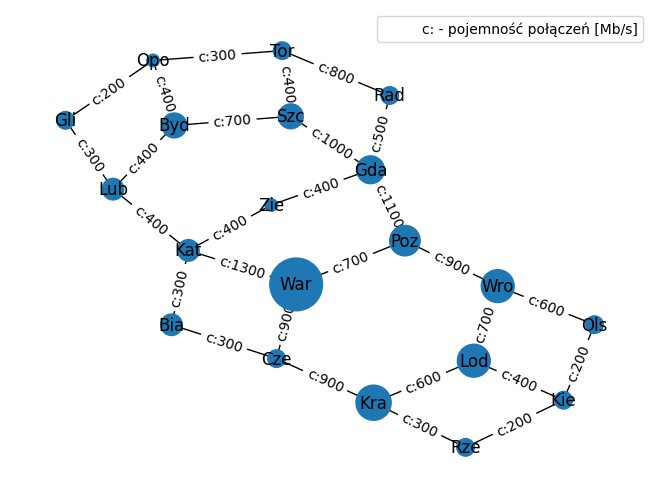

In [702]:
nodes = range(CITIES_NUMBER)
edges = []
for link in LINKS:
    edges.append((CITIES_LIST.index(link[0]), CITIES_LIST.index(link[1])))

node_sizes = []
node_labels = {}
edge_labels = {}

for id, city in enumerate(zip(CITIES_LIST, POPULATION_LIST)):
    node_sizes.append(city[1] * 800)
    node_labels[id] = city[0][:3]

for v1, v2, capacity in LINKS:
    idx1 = CITIES_LIST.index(v1)
    idx2 = CITIES_LIST.index(v2)
    edge_labels[(idx1, idx2)] = "c:{}".format(int(capacity))

network_graph = nx.Graph()
network_graph.add_nodes_from(nodes)
network_graph.add_edges_from(edges)

pos = nx.kamada_kawai_layout(network_graph)
nx.draw(G=network_graph, pos=pos, node_size=node_sizes, labels=node_labels, with_labels=True)   
nx.draw_networkx_edge_labels(G=network_graph, pos=pos, edge_labels=edge_labels)

plt.plot([], [], ' ', label="c: - pojemność połączeń [Mb/s]")
plt.legend()
plt.show()

In [703]:
AVERAGE_TRAFFIC_PER_USER = 0.001   # packets/s
AVERAGE_PACKET_SIZE = 12000        # bits / packet
ADMISSIBLE_AVERAGE_DELAY = 80      # miliseconds

gen_func = lambda i, j: AVERAGE_TRAFFIC_PER_USER * (POPULATION_LIST[int(i)] + POPULATION_LIST[int(j)]) / 2 * 10**6
TRAFFIC_MATRIX = np.fromfunction(np.vectorize(gen_func), (CITIES_NUMBER, CITIES_NUMBER), dtype=float)

In [704]:
def calculate_loads(network, traffic):
    loads = np.zeros((CITIES_NUMBER, CITIES_NUMBER))
    paths = dict(nx.all_pairs_shortest_path(network))

    for v1 in paths.keys():
        for v2 in paths[v1].keys():
            for i in range(len(paths[v1][v2]) - 1):
                u1 = paths[v1][v2][i]
                u2 = paths[v1][v2][i + 1]

                loads[u1][u2] += traffic[v1][v1]

    return loads

In [705]:
def calculate_delay(network, loads, traffic, capacities):
    delay_components = {}
    average_delay = 0
    
    for v1, v2 in network.edges():
        component = loads[v1][v2] / (capacities[v1][v2] * 10**6 / AVERAGE_PACKET_SIZE - loads[v1][v2]) * 10**6 / np.sum(traffic)
        average_delay += component
        delay_components[(v1, v2)] = component

    return delay_components, average_delay
    

In [706]:
loads = calculate_loads(network_graph, TRAFFIC_MATRIX)
delay_components, delay_average = calculate_delay(network_graph, loads, TRAFFIC_MATRIX, CAPACITIES_MATRIX)

print(delay_average)

42.908504936081854


In [707]:
N = 1000

def experiment(network_graph, edge_reliability, traffic_matrix_scale, capacities_matrix_scale):
    successes = 0
    fails = 0
    fails_incoherent = 0
    fails_too_much_load = 0
    fails_too_much_delay = 0

    to_much_load_fail_edges = []
    to_much_delay_fail_edges = []

    for i in range(N):
        graph = network_graph.copy()
        for edge in graph.edges:
            if random.random() > edge_reliability:
                graph.remove_edge(*edge)

        if not nx.is_connected(graph):
            fails += 1
            fails_incoherent += 1
            continue

        current_capacities = CAPACITIES_MATRIX * capacities_matrix_scale    # Mb / s
        current_traffic = TRAFFIC_MATRIX * traffic_matrix_scale             # packets / s

        loads = calculate_loads(graph, current_traffic)

        any_fail = False
        for v1, v2 in graph.edges():
            if current_capacities[v1][v2] * 10**6 < loads[v1][v2] * AVERAGE_PACKET_SIZE:
                any_fail = True
                to_much_load_fail_edges.append(
                    (CITIES_LIST[v1], CITIES_LIST[v2], 
                    (loads[v1][v2] * AVERAGE_PACKET_SIZE - current_capacities[v1][v2] * 10**6) / 10**6 ))

        if any_fail:
            fails += 1
            fails_too_much_load += 1
            continue

        delay_components, average_delay = calculate_delay(graph, loads, current_traffic, current_capacities)   

        if not average_delay <= ADMISSIBLE_AVERAGE_DELAY:
            sorted_delay_components = sorted(list(delay_components.items()), key=lambda element: element[1], reverse=True)[:5]
            to_much_delay_fail_edges += [(CITIES_LIST[x[0][0]], CITIES_LIST[x[0][1]], x[1]) for x in sorted_delay_components]

            fails += 1
            fails_too_much_delay += 1
            continue

        successes += 1

    return successes / N, fails / N, fails_incoherent / N, fails_too_much_load / N, fails_too_much_delay / N, sorted(to_much_load_fail_edges, key=lambda x: x[2], reverse=True), sorted(to_much_delay_fail_edges, key=lambda x: x[2], reverse=True)


In [708]:
successes, fails, incoherent_error, load_error, delay_error, to_much_load_fail_edges, to_much_delay_fail_edges = experiment(network_graph, 0.995, 1, 1)

print("SUCCESS RATE: {:.2f}".format(successes))
print("FAILS RATE: {:.2f}".format(fails))
print("    INCOHERENT: {:.2f}".format(incoherent_error))
print("    TO MUCH LOAD: {:.2f}".format(load_error))
print("    TO MUCH DELAY: {:.2f}".format(delay_error))
print('')

print('Overloaded edges: [deficit in Mb/s]')
print(sorted(to_much_load_fail_edges, key=lambda x: x[2], reverse=True))
print('')

print('Most delayed edges: [in milis]')
print(sorted(to_much_delay_fail_edges, key=lambda x: x[2], reverse=True))
print('')

SUCCESS RATE: 1.00
FAILS RATE: 0.00
    INCOHERENT: 0.00
    TO MUCH LOAD: 0.00
    TO MUCH DELAY: 0.00

Overloaded edges: [deficit in Mb/s]
[]

Most delayed edges: [in milis]
[('Rzeszow', 'Kielce', 142.8571428571426), ('Krakow', 'Rzeszow', 87.05357142857143), ('Kielce', 'Olsztyn', 5.76490438695163), ('Warszawa', 'Czestochowa', 3.0663780663780664), ('Lublin', 'Gliwice', 2.649325626204239)]



In [709]:
def draw_chart(x_values, successes, incoherent_errors, load_errors, delay_errors, title, x_label, y_label, y_range, x_scale):
    plt.plot([],[], color='g', label = 'sukces')
    plt.plot([],[], color='r', label = 'niespójność sieci')
    plt.plot([],[], color='b', label = 'przeładowanie łącza')
    plt.plot([],[], color='y', label = 'za duże opóźnienie')
    plt.stackplot(x_values, successes, incoherent_errors, load_errors, delay_errors, colors=['g', 'r', 'b', 'y'])

    plt.legend(loc='lower left')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(*y_range)
    plt.xscale(x_scale)
    plt.show()

/tmp/ipykernel_16844/2563959470.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  component = loads[v1][v2] / (capacities[v1][v2] * 10**6 / AVERAGE_PACKET_SIZE - loads[v1][v2]) * 10**6 / np.sum(traffic)


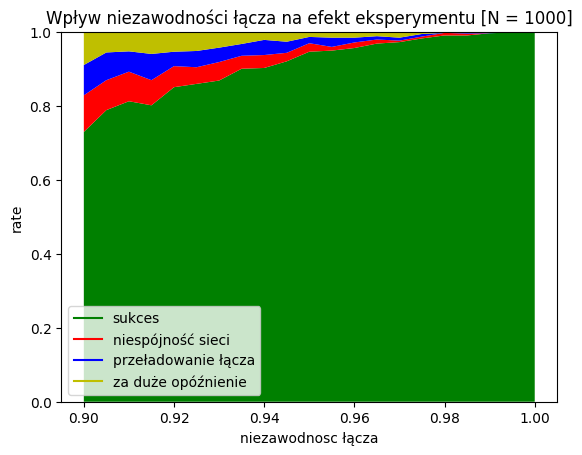

In [710]:
probabilities = [i / 1000 for i in range(900, 1005, 5)]

successes = []
incoherent_errors = []
load_errors = [] 
delay_errors = []

for p in probabilities:
    s, f, i, l, d, e1, e2 = experiment(network_graph, p, 1, 1)
    successes.append(s)
    incoherent_errors.append(i)
    load_errors.append(l)
    delay_errors.append(d)

draw_chart(probabilities, successes, incoherent_errors, load_errors, delay_errors, 
    'Wpływ niezawodności łącza na efekt eksperymentu [N = ' + str(N) + ']', 'niezawodnosc łącza', 'rate', (0,1), 'linear')

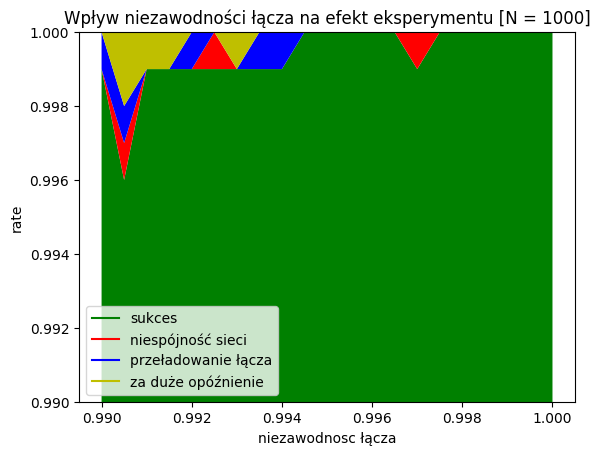

In [711]:
probabilities = [i / 10000 for i in range(9900, 10005, 5)]

successes = []
incoherent_errors = []
load_errors = [] 
delay_errors = []

for p in probabilities:
    s, f, i, l, d, e1, e2 = experiment(network_graph, p, 1, 1)
    successes.append(s)
    incoherent_errors.append(i)
    load_errors.append(l)
    delay_errors.append(d)

draw_chart(probabilities, successes, incoherent_errors, load_errors, delay_errors, 
    'Wpływ niezawodności łącza na efekt eksperymentu [N = ' + str(N) + ']', 'niezawodnosc łącza', 'rate', (0.99,1), 'linear')

[]


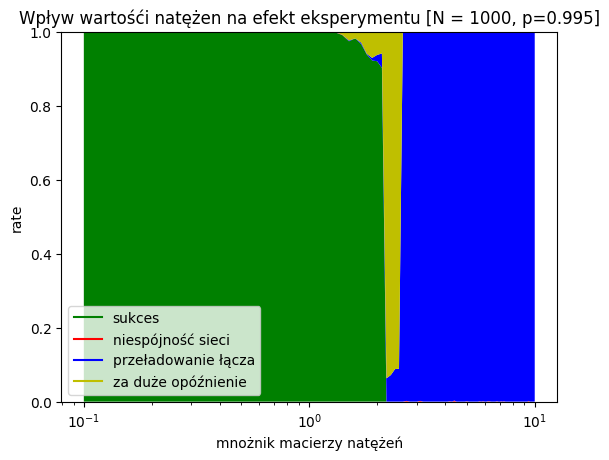

In [712]:
intensitive_matrix_scales = [i / 10 for i in range(1, 101)]

successes = []
incoherent_errors = []
load_errors = [] 
delay_errors = []

err = []

for k in intensitive_matrix_scales:
    s, f, i, l, d, e1, e2 = experiment(network_graph, 0.995, k, 1)
    successes.append(s)
    incoherent_errors.append(i)
    load_errors.append(l)
    delay_errors.append(d)

print(sorted(err, key=lambda x: x[2], reverse=True)[:100])

draw_chart(intensitive_matrix_scales, successes, incoherent_errors, load_errors, delay_errors, 
    'Wpływ wartośći natężen na efekt eksperymentu [N = ' + str(N) + ', p=0.995]', 'mnożnik macierzy natężeń', 'rate', (0,1), 'log')

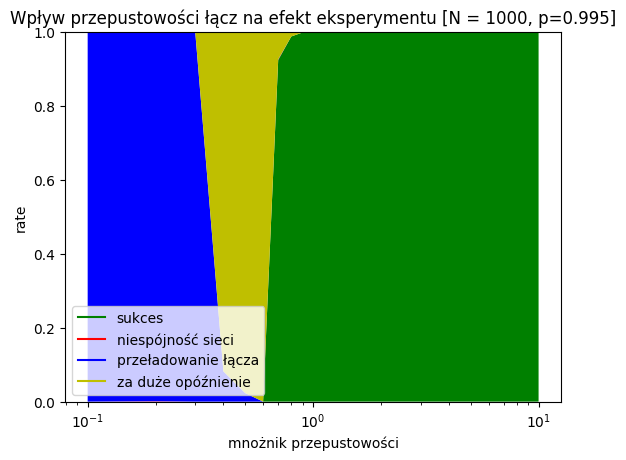

In [713]:
load_scales = [i / 10 for i in range(1, 101)]

successes = []
incoherent_errors = []
load_errors = [] 
delay_errors = []

for l in load_scales:
    s, f, i, l, d, e1, e2 = experiment(network_graph, 0.995, 1, l)
    successes.append(s)
    incoherent_errors.append(i)
    load_errors.append(l)
    delay_errors.append(d)

draw_chart(load_scales, successes, incoherent_errors, load_errors, delay_errors, 
    'Wpływ przepustowości łącz na efekt eksperymentu [N = ' + str(N) + ', p=0.995]', 'mnożnik przepustowości', 'rate', (0,1), 'log')

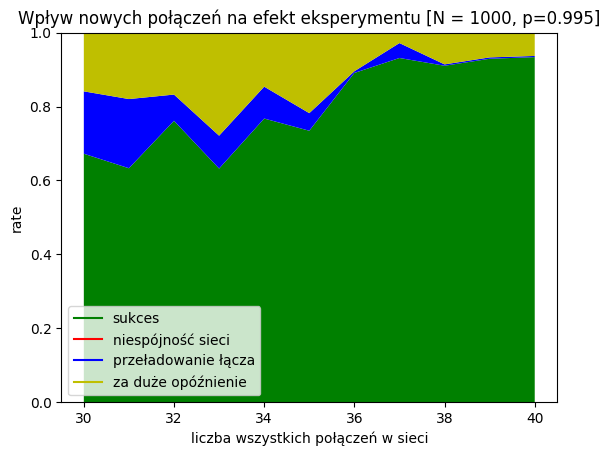

In [716]:
target_number_of_edges = list(range(30, 41))

successes = []
incoherent_errors = []
load_errors = [] 
delay_errors = []

avg_edge_capacity = np.mean(CAPACITIES_MATRIX)

nodes = list(network_graph.nodes())
for t in target_number_of_edges:
    s_sum = 0
    i_sum = 0
    l_sum = 0
    d_sum = 0
    for n in range(50):
        graph_copy = network_graph.copy()
        while len(graph_copy.edges()) != t:
            v1, v2 = random.choices(nodes, k=2)
            while network_graph.has_edge(v1, v2):
                v1, v2 = random.choices(nodes, k=2)
            graph_copy.add_edge(v1, v2)
            
            CAPACITIES_MATRIX[v1][v2] = avg_edge_capacity
            CAPACITIES_MATRIX[v2][v1] = avg_edge_capacity

        s, f, i, l, d, e1, e2 = experiment(graph_copy, 0.995, 1, 1)
        s_sum += s
        i_sum += i
        l_sum += l
        d_sum += d

    successes.append(s_sum / 50)
    incoherent_errors.append(i_sum / 50)
    load_errors.append(l_sum / 50)
    delay_errors.append(d_sum / 50)  

draw_chart(target_number_of_edges, successes, incoherent_errors, load_errors, delay_errors, 
    'Wpływ nowych połączeń na efekt eksperymentu [N = ' + str(N) + ', p=0.995]', 'liczba wszystkich połączeń w sieci', 'rate', (0,1), 'linear')      